#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid') # задаём стиль графиков всего документа

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

In [2]:
try:  #  чтение файла с сайта
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:  #  чтение файла локально
    df = pd.read_csv("C:\\Users\dedal\OneDrive\Рабочий стол\Яндекс.Практикум\Часть 12. Временные ряды\Проект\\taxi.csv",
                     index_col=[0], parse_dates=[0])

## Обзор данных

In [3]:
display(df.head())
print('--------------------------------------')
print('Размер:')
print(df.shape)
print('--------------------------------------')
print('Информация:')
print(df.info())
print('--------------------------------------')
print('Дубликаты:')
print(df.duplicated().sum())
print('--------------------------------------')
print('Пропуски:')
print(df.isna().sum())
print('--------------------------------------')
print('Описание данных:')
display(df.describe(include='all'))
print('Проверка на монотонное возрастание:', df.index.is_monotonic)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


--------------------------------------
Размер:
(26496, 1)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
--------------------------------------
Дубликаты:
26415
--------------------------------------
Пропуски:
num_orders    0
dtype: int64
--------------------------------------
Описание данных:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Проверка на монотонное возрастание: True


В качестве индекса установлен столбец "datetime", тип данных соответствует смыслу.

Дубликатов много, это связано с тем, что содержательный столбец только один, и каждое совпадение чисел становится дубликатом. 

Пропусков нет.


Проведём ресемплирование по одному часу, просуммируем количество заказов за каждый час:

In [4]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Посмотрим на частотную гистограмму значений датафрейма:

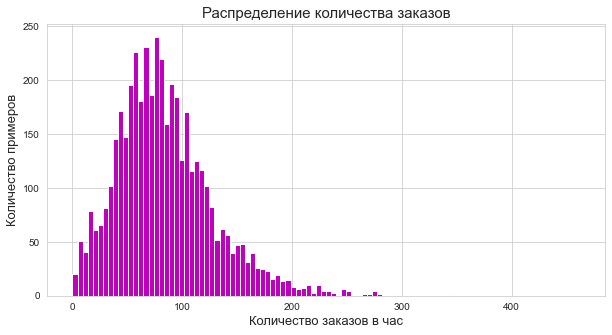

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(df, bins = 100, color = 'm')
plt.xlabel('Количество заказов в час', fontsize = 13)
plt.ylabel('Количество примеров', fontsize = 13)
plt.title('Распределение количества заказов', fontsize = 15)
plt.grid(True)
plt.show()

Гистограмма выглядит правдоподобно, график напоминает распределение Пуассона, подготовка данных закончена.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

### Скользящее среднее

Для начала узнаем, за сколько лет у нас есть наблюдения:

Посмотрим скользящее среднее за сутки за март-июнь:

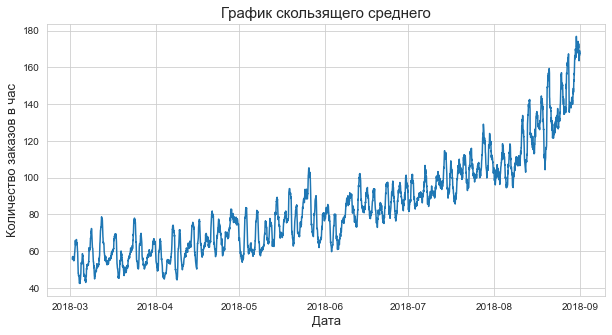

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(df.rolling(24).mean())
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Количество заказов в час', fontsize = 13)
plt.title('График скользящего среднего', fontsize = 15)
plt.grid(True)
plt.show()

Виден тренд - возрастание количества заказов.

### Скользящее стандартное отклонение

Исследуем скользящее среднее и скользящее стандартное отклонение.

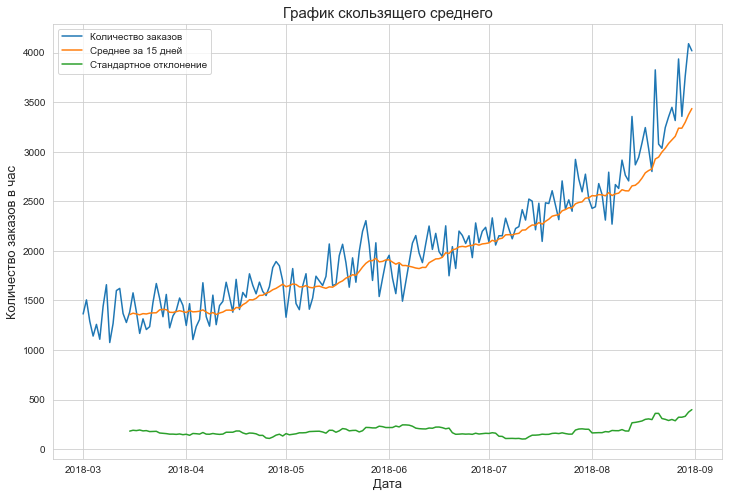

In [8]:
data_plot = df.resample('1D').sum() # ресемплируем по 1 дню
data_plot['mean'] = data_plot['num_orders'].rolling(15).mean() # среднее за 15 дней
data_plot['std'] = data_plot['num_orders'].rolling(15).std() # отклонение
plt.figure(figsize=(12, 8))
plt.plot(data_plot)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Количество заказов в час', fontsize = 13)
plt.title('График скользящего среднего', fontsize = 15)
plt.grid(True)
plt.legend(['Количество заказов', 'Среднее за 15 дней', 'Стандартное отклонение'])
plt.show()

Стохастический процесс нестационарный - меняется и среднее, и отклонения. Прогнозировать такой ряд сложнее, чем стационарный.

### Сезонность, тренд и шум.

Воспользуемся модулем tsa.seasonal библиотеки
statsmodels.

Функция seasonal_decompose() раскладывает
временной ряд на три составляющие: тренд, сезонность и остаток (шум).



In [9]:
decomposed = seasonal_decompose(df)

Посмотрим на тренд, сезонность и остаток за первые 15 дней апреля

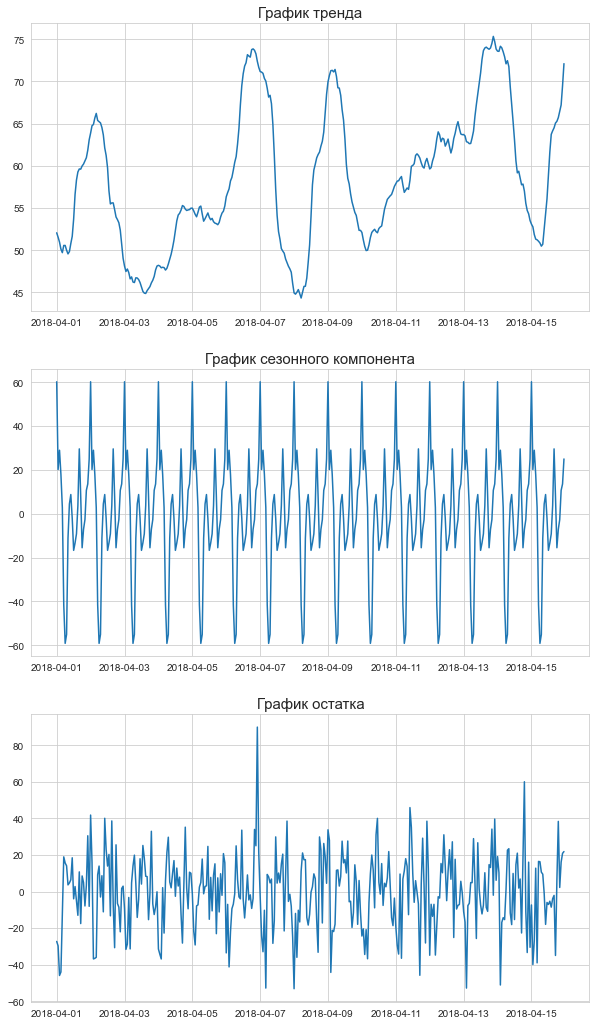

In [10]:
fig, ax = plt.subplots(figsize=(10, 18), nrows=3, ncols=1);

ax[0].plot(decomposed.trend['2018-04-01':'2018-04-15']) 
ax[0].set_title('График тренда', fontsize = 15)
ax[1].plot(decomposed.seasonal['2018-04-01':'2018-04-15'])
ax[1].set_title('График сезонного компонента', fontsize = 15)
ax[2].plot(decomposed.resid['2018-04-01':'2018-04-15'])
ax[2].set_title('График остатка', fontsize = 15);

По графикам видно, что есть чёткая сезонность внутри каждого дня, есть некоторый тренд внутри месяца - количество заказов то растёт, то падает. 

Если взять больший промежуток времени, графики сезонности и остатков сливаются.

Попробуем совместить на одном графике:

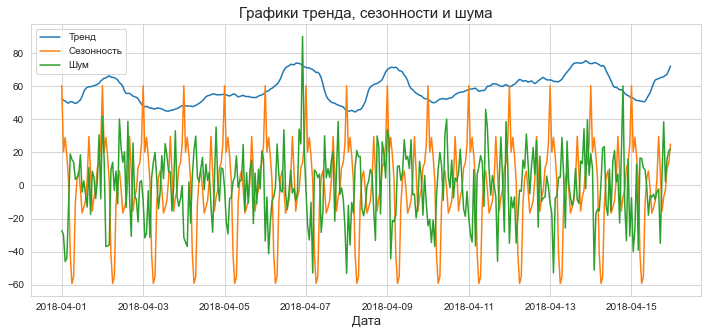

In [11]:
data_plot = pd.DataFrame(decomposed.trend['2018-04-01':'2018-04-15']
            ).join(
    pd.DataFrame(decomposed.seasonal['2018-04-01':'2018-04-15']
            )).join(
    pd.DataFrame(decomposed.resid['2018-04-01':'2018-04-15']
            ))

plt.figure(figsize=(12, 5))
plt.plot(data_plot)
plt.xlabel('Дата', fontsize = 13)
plt.title('Графики тренда, сезонности и шума', fontsize = 15)
plt.grid(True)
plt.legend(['Тренд', 'Сезонность', 'Шум'])
plt.show()

Возьмём другой случайный промежуток времени - первые 15 дней июля.

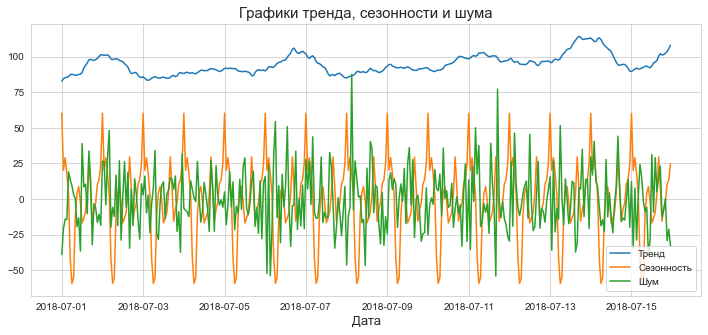

In [12]:
data_plot = pd.DataFrame(decomposed.trend['2018-07-01':'2018-07-15']
            ).join(
pd.DataFrame(decomposed.seasonal['2018-07-01':'2018-07-15']
            )).join(
pd.DataFrame(decomposed.resid['2018-07-01':'2018-07-15']
            ))

plt.figure(figsize=(12, 5))
plt.plot(data_plot)
plt.xlabel('Дата', fontsize = 13)
plt.title('Графики тренда, сезонности и шума', fontsize = 15)
plt.grid(True)
plt.legend(['Тренд', 'Сезонность', 'Шум'])
plt.show()

Посмотрим отдельно на тренд:

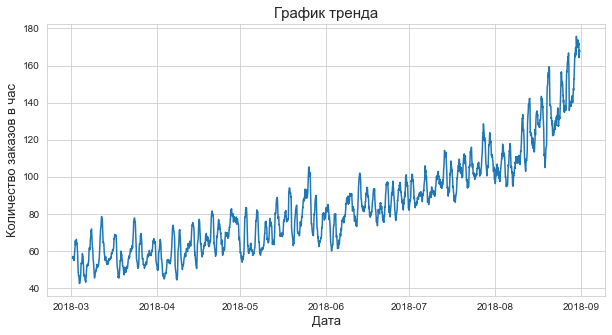

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(decomposed.trend)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Количество заказов в час', fontsize = 13)
plt.title('График тренда', fontsize = 15)
plt.grid(True)
plt.show()

В целом количество заказов растёт со временем.

## Обучение

### Создание признаков

Функция для создания признаков:
- Календарных (год, месяц, день, день недели),
- "Отстающие значения"
- Скользящее среднее

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    new_df = df.copy()
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['hour'] = new_df.index.hour
    
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    new_df = new_df.dropna()
    return new_df

Создадим признаки с максимальным отставание на 10 и ширину окна для скользящего среднего 3.

In [15]:
df = make_features(df, 12, 3)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,76.333333
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,63.333333
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,52.666667
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,36.666667
2018-03-01 16:00:00,43,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,48.666667


### Разделение на выборки.

Разделим исходные данные на обучающую, валидационную и тестовую выборки.
- Обучающая выборка - 80%
- Валидационная выборка - 10%
- Тестовая выборка - 10%

Затем разделим валидационную и обучающую выборки:

In [16]:
df_train_and_valid, df_test = train_test_split(
    df, test_size=0.1, # разделяем 90% и 10% датасета
    shuffle = False,
    random_state=12345 
)
df_train, df_valid = train_test_split(
    df_train_and_valid, test_size=0.11, 
    shuffle = False,
    random_state=12345,  # разделяем датасет, это будет 80 и 10% исходного
)
print("Train/Valid/Test:", df_train.shape, df_valid.shape, df_test.shape)

Train/Valid/Test: (3527, 18) (436, 18) (441, 18)


Выделение признаков:

In [17]:
features_train = df_train.drop('num_orders', axis = 1)
features_valid = df_valid.drop('num_orders', axis = 1)
features_test = df_test.drop('num_orders', axis = 1)

target_train = df_train['num_orders']
target_valid = df_valid['num_orders']
target_test = df_test['num_orders']

### Модель Линейная регрессия

In [18]:
LinReg = LinearRegression(
    normalize = True, 
    n_jobs = -1)
LinReg.fit(features_train, target_train)
predicted_valid = LinReg.predict(features_valid)
rmse_linear = mean_squared_error(target_valid, predicted_valid, squared=False)
print('RMSE =', round(rmse_linear, 2))

RMSE = 40.26



### Модель Решающее дерево

#### Подбор гиперпараметров

Напишем цикл для нахождения оптимальной глубины дерева решений:

In [19]:
tcv = TimeSeriesSplit(n_splits=5)
model = DecisionTreeRegressor(random_state=12345)
param_search = {'max_depth' : range(1, 10)}
TreeGrid = GridSearchCV(model, 
                        cv=tcv, 
                        param_grid=param_search, 
                        scoring ='neg_root_mean_squared_error')
TreeGrid.fit(features_train, target_train)
print("Наилучшая глубина =", TreeGrid.best_params_['max_depth'])

Наилучшая глубина = 7


#### Обучение модели

Работа модели с оптимальной глубиной на валидационной выборке:

In [20]:
TreeReg = TreeGrid.best_estimator_.fit(features_train, target_train)
predicted_valid = TreeReg.predict(features_valid)
rmse_tree = mean_squared_error(target_valid, predicted_valid, squared=False)
print('RMSE =', round(rmse_tree, 2))

RMSE = 36.51


### Модель Случайный лес

#### Подбор гиперпараметров

Напишем цикл для нахождения оптимального числа деревьев и глубины дерева:

In [21]:
model = RandomForestRegressor(random_state=12345, n_jobs = -1)
param_search = {'n_estimators': range(50, 120, 10),
                'max_depth'   : range(5, 20)}
ForestGrid = GridSearchCV(model, 
                          cv=tcv, 
                          param_grid=param_search, 
                          scoring ='neg_root_mean_squared_error')
ForestGrid.fit(features_train, target_train)
print("Наилучшие гиперпараметры:", ForestGrid.best_params_)

Наилучшие гиперпараметры: {'max_depth': 15, 'n_estimators': 100}


#### Обучение модели

Выполним обучение модели с наилучшими гиперпараметрами:

In [22]:
ForestReg = ForestGrid.best_estimator_.fit(features_train, target_train)
ForestReg.fit(features_train, target_train) 
predicted_valid = ForestReg.predict(features_valid) 
rmse_forest = mean_squared_error(target_valid, predicted_valid, squared=False) 
print("RMSE =", round(rmse_forest, 2))

RMSE = 31.74


### Модель CatBoost 

#### Подбор гиперпараметров

Внесём изменения в некоторые параметры, которые могут сильно повлиять на результат обучения. Это максимальная глубина дерева depth, скорость обучения learning_rate и количество деревьев в ансамбле iterations.

In [23]:
model = CatBoostRegressor(random_state=12345, loss_function="RMSE")
param_search = {'iterations'   : range(100, 300, 20),
                'depth'        : range(2, 6),
                'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12]}
CatGrid = GridSearchCV(model, 
                       cv=tcv, 
                       param_grid=param_search, 
                       scoring ='neg_root_mean_squared_error')
CatGrid.fit(features_train, target_train, verbose = False)
print("Наилучшие гиперпараметры:", CatGrid.best_params_)

Наилучшие гиперпараметры: {'depth': 4, 'iterations': 260, 'learning_rate': 0.1}


#### Обучение модели

Работа модели с наилучшими гиперпараметрами:

In [24]:
CatBReg = CatGrid.best_estimator_.fit(features_train, target_train, verbose=False)
predicted_valid = CatBReg.predict(features_valid)
rmse_cat = mean_squared_error(target_valid, predicted_valid, squared=False) # считаем RMSE
print("RMSE =", round(rmse_cat, 2))

RMSE = 31.4


### Константная модель 

Для проверки моделей на адекватность сравним их работу с константной моделью, которая всегда даёт в качестве ответа медианное значение целевого признака в обучающей выборке.

In [25]:
median_const = target_train.median()
predicted_valid = pd.Series([median_const]*len(target_valid))
rmse_constant = mean_squared_error(target_valid, predicted_valid, squared=False) # считаем RMSE
print("RMSE =", round(rmse_constant, 2))

RMSE = 59.79


### Сравнение моделей

Соберём результаты всех моделей:

,RMSE
model,
CatBoost,31.399056
Random Forest,31.744940
Decision Tree,36.505974
Linear Regression,40.258495
Сonstant,59.789597


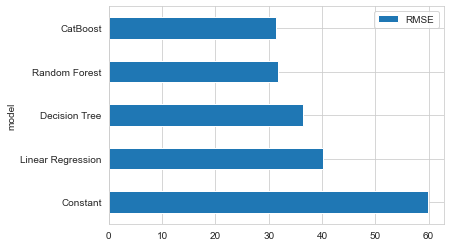

In [26]:
models_analysis = pd.DataFrame(
    data = [
    ['Linear Regression', rmse_linear],
    ['Decision Tree', rmse_tree],
    ['Random Forest', rmse_forest],
    ['CatBoost', rmse_cat],
    ['Сonstant', rmse_constant]
],  columns = ['model', 'RMSE']
).set_index('model')

display(models_analysis.sort_values(by ='RMSE'))
models_analysis.sort_values(by ='RMSE', ascending = False).plot.barh();

Все модели проходят проверку на адекватность, их RMSE меньше, чем у константной модели.

Самое низкое значение среднеквадратической ошибки у модели CatBoost.

## Тестирование

Для тестирования обучим модель на обучающей + валидационной выборке:

In [27]:
features_train = df_train_and_valid.drop('num_orders', axis = 1)
target_train = df_train_and_valid['num_orders']

In [28]:
CatBReg = CatGrid.best_estimator_.fit(features_train, target_train, verbose=False)
predicted_test = CatBReg.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test, squared=False) 
print("RMSE:", round(rmse, 2))

RMSE: 45.14


Сравним реальные и предсказанные значения на графиках:

In [29]:
# собираем датафрейм для сравнения
pred_targ_compare = pd.DataFrame(
    {'datetime' :target_test.index, 
     'target'   :target_test.values,
     'predicted':predicted_test}
    ).set_index('datetime')
pred_targ_compare

,target,predicted
datetime,,
2018-08-13 15:00:00,175,107.732571
2018-08-13 16:00:00,144,137.262531
2018-08-13 17:00:00,152,126.190830
2018-08-13 18:00:00,104,104.941432
2018-08-13 19:00:00,91,96.393309
...,...,...
2018-08-31 19:00:00,136,124.044816
2018-08-31 20:00:00,154,135.801621
2018-08-31 21:00:00,159,135.612523


Первые 6 дней:

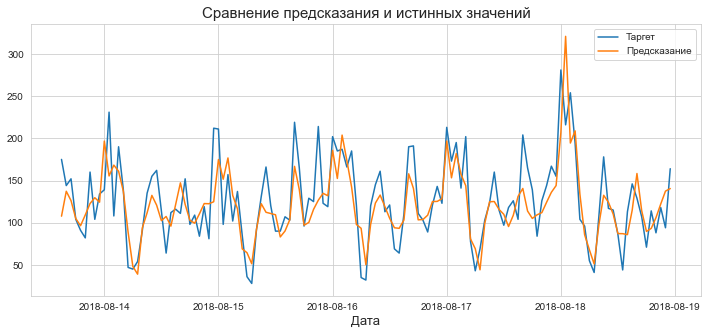

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(pred_targ_compare['2018-08-13':'2018-08-18'])
plt.xlabel('Дата', fontsize = 13)
plt.title('Сравнение предсказания и истинных значений', fontsize = 15)
plt.grid(True)
plt.legend(['Таргет', 'Предсказание'])
plt.show()

Следующие 6 дней:

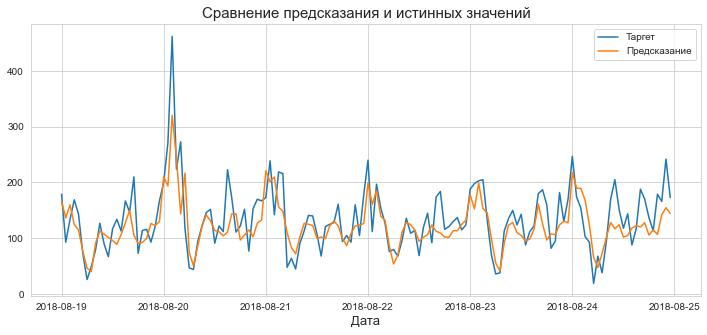

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(pred_targ_compare['2018-08-19':'2018-08-24'])
plt.xlabel('Дата', fontsize = 13)
plt.title('Сравнение предсказания и истинных значений', fontsize = 15)
plt.grid(True)
plt.legend(['Таргет', 'Предсказание'])
plt.show()

Последние 7 дней:

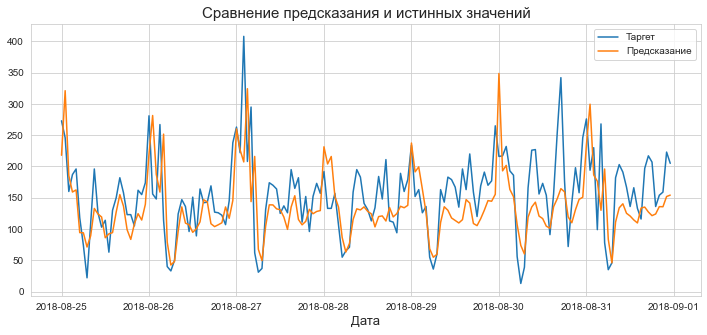

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(pred_targ_compare['2018-08-25':'2018-08-31'])
plt.xlabel('Дата', fontsize = 13)
plt.title('Сравнение предсказания и истинных значений', fontsize = 15)
plt.grid(True)
plt.legend(['Таргет', 'Предсказание'])
plt.show()

Предсказание проходит достаточно близко к реальным значениям.

### Вывод:
- Выполнено ресемплирование данных по 1 часу, поскольку предсказывать необходимо количество заказов на следующий час.
- Проведён анализ данных:
    - Наблюдаются стабильные колебания спроса в теление суток,
    - Тренд общего числа заказов - возрастающий,
    - Временной ряд описывается нестационарным стохастическим процессом. Прогнозировать такой ряд сложнее, чем стационарный.
- Для предсказания количества заказов на следующий час построена модель машинного обучения.
- Модель позволит привлекать оптимальное количество водителей в зависимости от предсказанной нагрузки.
- Для предсказания выбрана модель CatBoostRegressor, подобраны оптимальные гиперпараметры модели. 
- Достигнутое значение среднеквадратической ошибки составляет 45.14 при пороговом 48 - подбор модели выполнен успешно.